In [1]:
import os
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats

## 1) Loading in the data

In [2]:
dataPath = 'Data/2016-2019(One station)/shair-8781-1-6-1.csv'
airQualityData=pd.read_csv(dataPath, header=14,sep=';').rename(columns={'Start':'Start','Slut':'Stop'})
airQualityData.rename(columns = lambda x: re.sub('NOX.*','NOX',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('PM10.*','PM10',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('PM2.5.*','PM2_5',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('NO2.*','NO2',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('O3.*','O3',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('Black Carbon.*','Black Carbon',x), inplace = True)
airQualityData['Start'] = pd.to_datetime(airQualityData['Start'])
airQualityData= airQualityData.drop('Stop',axis=1)
one_feature=airQualityData.drop(columns=['Black Carbon','NO2','NOX','O3','PM2_5'])
one_feature.head(5)

,Start,PM10
0,2015-01-01 00:00:00,28.4
1,2015-01-01 01:00:00,8.5
2,2015-01-01 02:00:00,8.7
3,2015-01-01 03:00:00,10.5
4,2015-01-01 04:00:00,12.1


## 2) Creating the train and testing set

In [84]:
train=one_feature[(one_feature['Start']<= "2018-12-31 23:00:00")]
test=one_feature[(one_feature['Start'] >= "2019-12-01 00:00:00")]

In [ ]:
#TODO MIN-MAX SCALE

### Training set

In [71]:
training_set=train['PM10']
X_train = []
y_train = []
for i in range(5, len(training_set)):
    X_train.append(training_set[i-5:i])
    y_train.append(training_set[i])
    
X_train, y_train = np.array(X_train), np.array(y_train)
print (X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#-------------------------------------#
#Deleting the samples that contain nan
index=[]
for i in range(0,len(X_train)):
    if np.isnan(X_train[i]).any() or np.isnan(y_train[i]):
        index.append(i)
X_train_new=np.delete(X_train,index, axis=0)
y_train_new=np.delete(y_train,index)

(35059, 5)


### Testing set

In [99]:
testing_set=test['PM10']
testing_set=testing_set.reset_index()
testing_set=testing_set['PM10']
X_test = []
y_test = []
for i in range(5, len(testing_set)):
    X_test.append(testing_set[i-5:i])
    y_test.append(testing_set[i])
    
X_test, y_test = np.array(X_test), np.array(y_test)
print (X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#-------------------------------------#
#Deleting the samples that contain nan
index=[]
for i in range(0,len(X_test)):
    if np.isnan(X_test[i]).any() or np.isnan(y_test[i]):
        index.append(i)
X_test_new=np.delete(X_test,index, axis=0)
y_test_new=np.delete(y_test,index)

(739, 5)


0      6.9
1      5.3
2      4.4
3      3.5
4      3.4
      ... 
739    6.4
740    4.5
741    3.0
742    2.8
743    4.6
Name: PM10, Length: 744, dtype: float64

## 3) Model creation 

In [68]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train_new, y_train_new, epochs = 15, batch_size = 32)

Epoch 1/15
33156/33156 [==============================] - 72s 2ms/step - loss: 46.9688
Epoch 2/15
33156/33156 [==============================] - 71s 2ms/step - loss: 26.2662
Epoch 3/15
33156/33156 [==============================] - 70s 2ms/step - loss: 24.7479
Epoch 4/15
33156/33156 [==============================] - 70s 2ms/step - loss: 24.0243
Epoch 5/15
33156/33156 [==============================] - 71s 2ms/step - loss: 23.5056
Epoch 6/15
33156/33156 [==============================] - 71s 2ms/step - loss: 23.5969
Epoch 7/15
33156/33156 [==============================] - 70s 2ms/step - loss: 23.2247
Epoch 8/15
33156/33156 [==============================] - 69s 2ms/step - loss: 23.0642
Epoch 9/15
33156/33156 [==============================] - 70s 2ms/step - loss: 23.0436
Epoch 10/15
33156/33156 [==============================] - 71s 2ms/step - loss: 22.9995
Epoch 11/15
33156/33156 [==============================] - 70s 2ms/step - loss: 22.8874
Epoch 12/15
33156/33156 [================

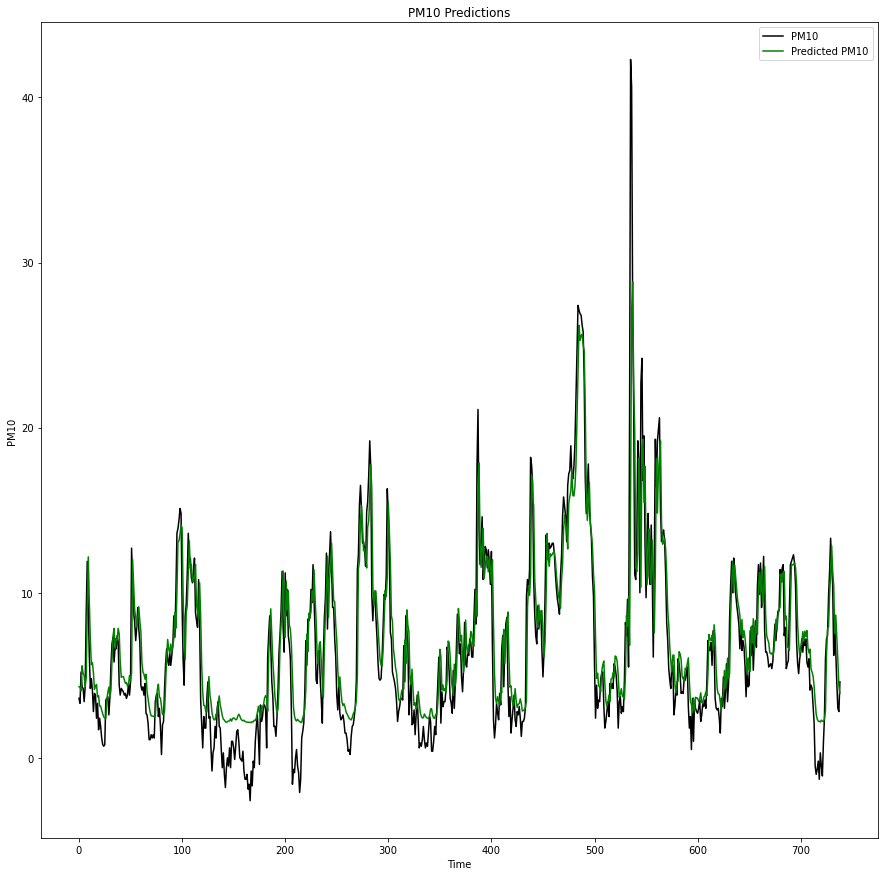

In [103]:
predicted = regressor.predict(X_test_new)
fig = plt.figure(figsize=(15,15))
plt.plot(y_test_new, color = 'black', label = 'PM10')
plt.plot(predicted, color = 'green', label = 'Predicted PM10')
plt.title('PM10 Predictions')
plt.xlabel('Time')
plt.ylabel('PM10')
plt.legend()
plt.show()